In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1672538583000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low     Volume
0     2023-01-01 10:29:59  1195.21  1196.12  1196.13  1195.02   775.1099
1     2023-01-01 10:44:59  1196.13  1195.27  1196.74  1195.27   745.9340
2     2023-01-01 10:59:59  1195.28  1195.40  1195.72  1195.27   535.4996
3     2023-01-01 11:14:59  1195.41  1193.20  1195.41  1192.28  3422.8530
4     2023-01-01 11:29:59  1193.19  1193.38  1193.40  1191.71  2262.1415
...                   ...      ...      ...      ...      ...        ...
8073  2023-03-26 13:59:59  1750.99  1753.24  1754.43  1750.74  2134.0302
8074  2023-03-26 14:14:59  1753.23  1753.54  1755.72  1751.43  1732.4756
8075  2023-03-26 14:29:59  1753.55  1751.33  1754.05  1750.61  1215.0042
8076  2023-03-26 14:44:59  1751.33  1750.74  1752.67  1750.41  2083.5783
8077  2023-03-26 14:59:59  1750.74  1750.43  1750.75  1750.42    35.1617

[8078 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 14, 50):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff()

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low     Volume  \
0     2023-01-01 10:29:59  1195.21  1196.12  1196.13  1195.02   775.1099   
1     2023-01-01 10:44:59  1196.13  1195.27  1196.74  1195.27   745.9340   
2     2023-01-01 10:59:59  1195.28  1195.40  1195.72  1195.27   535.4996   
3     2023-01-01 11:14:59  1195.41  1193.20  1195.41  1192.28  3422.8530   
4     2023-01-01 11:29:59  1193.19  1193.38  1193.40  1191.71  2262.1415   
...                   ...      ...      ...      ...      ...        ...   
8073  2023-03-26 13:59:59  1750.99  1753.24  1754.43  1750.74  2134.0302   
8074  2023-03-26 14:14:59  1753.23  1753.54  1755.72  1751.43  1732.4756   
8075  2023-03-26 14:29:59  1753.55  1751.33  1754.05  1750.61  1215.0042   
8076  2023-03-26 14:44:59  1751.33  1750.74  1752.67  1750.41  2083.5783   
8077  2023-03-26 14:59:59  1750.74  1750.43  1750.75  1750.42    35.1617   

            ema_8       ema_14       ema_50       atr        rsi      slowk  \
0       

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_14']
        # c4
        df['c4'] = df['ema_14'] >= df['ema_50']
        
        df['c5'] = df['rsi'] >= 60

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4 & df.c5, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_14,ema_50,atr,...,slowk,slowd,kd_cross,c1,c2,c3,c4,c5,signal,openbuy
0,2023-01-01 10:29:59,1195.21,1196.12,1196.13,1195.02,775.1099,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,2023-01-01 10:44:59,1196.13,1195.27,1196.74,1195.27,745.9340,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
2,2023-01-01 10:59:59,1195.28,1195.40,1195.72,1195.27,535.4996,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
3,2023-01-01 11:14:59,1195.41,1193.20,1195.41,1192.28,3422.8530,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
4,2023-01-01 11:29:59,1193.19,1193.38,1193.40,1191.71,2262.1415,NaN,NaN,NaN,0.000000,...,NaN,NaN,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8073,2023-03-26 13:59:59,1750.99,1753.24,1754.43,1750.74,2134.0302,1750.094244,1749.548955,1746.350704,3.893579,...,81.623450,48.515596,False,False,True,True,True,True,False,False
8074,2023-03-26 14:14:59,1753.23,1753.54,1755.72,1751.43,1732.4756,1750.859967,1750.081095,1746.632637,3.921895,...,77.572016,71.817504,False,False,True,True,True,True,False,False
8075,2023-03-26 14:29:59,1753.55,1751.33,1754.05,1750.61,1215.0042,1750.964419,1750.247615,1746.816848,3.887474,...,54.835391,71.343619,True,True,True,True,True,False,False,False
8076,2023-03-26 14:44:59,1751.33,1750.74,1752.67,1750.41,2083.5783,1750.914548,1750.313267,1746.970697,3.771225,...,48.765432,60.390947,False,False,False,True,True,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = buydf['Close']
atr_val = buydf['atr']

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price
        # set stop loss
        # 進場
    
    elif buydf.at[index, 'openbuy'] == True:
   
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = close_val.shift(1).at[index] - 3 * atr_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = buydf.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (buydf.at[index, 'High'] >= close_val.shift(1).at[index] + 3.5 * atr_val.shift(1).at[index]) and in_position == True:
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


               Close_Time     Open    Close     High      Low     Volume  \
59    2023-01-02 01:14:59  1197.35  1198.13  1198.68  1197.34  1235.3748   
60    2023-01-02 01:29:59  1198.13  1200.88  1203.50  1198.12  6835.3622   
61    2023-01-02 01:44:59  1200.88  1201.02  1201.68  1200.36  1427.5987   
63    2023-01-02 02:14:59  1200.67  1201.86  1202.91  1200.67  2545.1178   
64    2023-01-02 02:29:59  1201.86  1201.56  1202.00  1201.14   834.1322   
...                   ...      ...      ...      ...      ...        ...   
8058  2023-03-26 10:14:59  1751.70  1750.45  1752.95  1750.44  1905.6798   
8059  2023-03-26 10:29:59  1750.45  1751.40  1753.02  1750.34  1436.2966   
8060  2023-03-26 10:44:59  1751.39  1750.69  1753.07  1750.68  1191.0504   
8061  2023-03-26 10:59:59  1750.68  1752.59  1754.15  1750.68  1328.6545   
8062  2023-03-26 11:14:59  1752.58  1753.37  1753.84  1750.98  1206.8084   

            ema_8       ema_14       ema_50       atr  ...     c1    c2    c3  \
59    

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_14', 'ema_50', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



              Close_Time     Open    Close     High      Low        ema_8  \
0    2023-01-02 01:29:59  1198.13  1200.88  1203.50  1198.12  1197.819847   
1    2023-01-02 01:44:59  1200.88  1201.02  1201.68  1200.36  1198.530992   
2    2023-01-02 02:29:59  1201.86  1201.56  1202.00  1201.14  1200.068382   
3    2023-01-02 02:59:59  1201.47  1200.92  1201.48  1200.77  1200.501614   
4    2023-01-02 03:29:59  1203.33  1203.62  1204.51  1202.22  1201.683445   
..                   ...      ...      ...      ...      ...          ...   
659  2023-03-24 01:59:59  1829.26  1826.40  1831.29  1823.62  1823.384525   
660  2023-03-24 02:29:59  1828.48  1819.88  1829.46  1818.00  1823.488169   
661  2023-03-24 16:59:59  1802.08  1794.88  1802.09  1787.74  1805.675205   
662  2023-03-26 00:44:59  1756.40  1755.69  1757.76  1754.09  1753.570789   
663  2023-03-26 02:59:59  1744.83  1738.93  1745.04  1738.34  1745.105851   

          ema_14       ema_50        atr kd_cross position  entry_p  \
0   

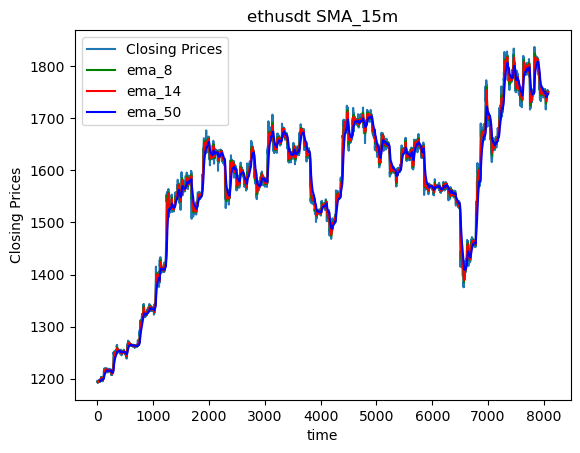

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')

plt.plot(df.ema_8, label='ema_8', c='g')
plt.plot(df.ema_14, label='ema_14', c='r')
plt.plot(df.ema_50, label='ema_50', c='b')
plt.legend()
plt.show()